# Predict Melbourne House Prices

This Notebook will show How to train a simple regression model using Xgboost. we will use the data set provided by [Kaggle](https://www.kaggle.com/anthonypino/melbourne-housing-market)

The Aim of this notebook is to train a small model that can then be used as boilerplate of a similar training code that will eventually be deployed to platform AI to demonstrate some aspects of MLOPs and how AI Platform makes it easier to set up your ML training pipelines.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from fastai.basics import *
from fastai.tabular.all import *
from xgboost import XGBRegressor
import pickle
import mlflow
import mlflow.xgboost
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import StratifiedKFold
import numpy as np
from functools import partial
import optuna
from optuna.samplers import TPESampler
import argparse
import json
import matplotlib.pyplot as plt

Check the version of MLFlow and The main directory for MLFlow tracking

In [2]:
print("MLflow Version:", mlflow.__version__)
print("MLflow Tracking URI:", mlflow.get_tracking_uri())

MLflow Version: 1.17.0
MLflow Tracking URI: file:///Users/GAKUBA/Documents/facileai-tutorials/melbourne-house-prices/melbourne-house-prices-local/mlruns


Adding a fastai helper that allows us to save the data processor object as pickle file.

## Define methods that will be needed in the training process for reusability

In [3]:
@patch
def export(self:TabularPandas, fname='export.pkl', pickle_protocol=2):
    "Export the contents of `self` without the items"
    old_to = self
    self = self.new_empty()
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        pickle.dump(self, open(Path(fname), 'wb'), protocol=pickle_protocol)
        self = old_to

The `get_data` method allows us to load data in a repeatable way

In [4]:
def get_data(data_pth,hptune):
    
    train_df = pd.read_csv(data_pth, low_memory=False)

    dep_var = 'Price'
    cont_nn = ['Rooms',  'Propertycount', 'Distance', 'Date_cpElapsed']
#     cat_nn = ['Suburb', 'Postcode', 'Street', 'Type', 'SellerG', 'Regionname', 'CouncilArea', 'Date_cpIs_month_end', 'Date_cpIs_month_start', 'Date_cpIs_quarter_end', 'Date_cpIs_quarter_start', 'Date_cpIs_year_end', 'Date_cpIs_year_start']
    cat_nn = ['Suburb', 'Postcode', 'Street', 'Type', 'SellerG', 'Regionname', 'CouncilArea','Date_cpIs_quarter_start']
    
    cols = set(list(train_df.columns.values)).intersection(set(cat_nn+cont_nn+[dep_var]))
    train_df = train_df[cols]
    
    
    if not hptune:
        features = {}
        features['cat'] = cat_nn
        features['cont'] = cont_nn
        features['dep_var'] = dep_var
        #save the best params to a file
        with open('artifacts/features.txt', 'w') as outfile:
            json.dump(features, outfile)
    
    procs_nn = [Categorify, FillMissing]
    to_nn = TabularPandas(train_df, procs_nn, cat_nn, cont_nn,
                        splits=None, y_names=dep_var)
    if not hptune:
        print('saving the data processor')
        to_nn.export('artifacts/data-proc.pkl')
    
    X_train,Y_train = to_nn.train.xs,to_nn.train.y

    return X_train,Y_train

In [5]:
def train(params, X, y,hptune, experiment_id=0):

    with mlflow.start_run(experiment_id=experiment_id) as run:
        run_id = run.info.run_uuid
        experiment_id = run.info.experiment_id

        print(f'MLflow run_id {run_id}, experiment_id {experiment_id}, experiment_name {client.get_experiment(experiment_id).name}')


        # MLflow params

        params['seed'] = 42
        for key, value in params.items():
#             print(key,'->', value)
            mlflow.log_param(key, value)
    
        model = XGBRegressor(**params)

        rmses = []
        maes = []
        r2s = []
        #Create stratified folds to avoid our model overfitting. we create 5 folds for this model
        kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        
        for idx in kf.split(X=X,y=y):
            train_idx, valid_idx = idx[0], idx[1]
            X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
            X_valid,  y_valid = X.iloc[valid_idx], y.iloc[valid_idx]

            model.fit(
                X_train, 
                y_train, 
                eval_metric="rmse", 
                eval_set=[(X_train, y_train), (X_valid, y_valid)], 
                verbose=False, 
                early_stopping_rounds = 50
            )

            predictions = model.predict(X_valid)
            
            rmse = np.sqrt(mean_squared_error(y_valid, predictions))
            rmses.append(rmse)
            mae = mean_absolute_error(y_valid, predictions)
            maes.append(mae)
            r2 = r2_score(y_valid, predictions)    
            r2s.append(r2)  
            
        # calculate the average of metrics for all folds
        avg_rmse = np.mean(rmses)
        avg_mae = np.mean(maes)
        avg_r2 = np.mean(r2s)
        
        # Log the metrics to MLflow metrics
        mlflow.log_metric("rmse", avg_rmse)
        mlflow.log_metric("r2", avg_r2)
        mlflow.log_metric("mae", avg_mae)


        # if this is not hypertuning save the model
        if not hptune:
            model_filename = './artifacts/model.pkl'
            with open(model_filename, 'wb') as model_file:
                pickle.dump(model, model_file)
            #Print rmse
            print(f'rmse: {avg_rmse}')
        return avg_rmse

In [6]:
def objective(trial, X, y, hptune=True, experiment_id=0):

    params = {
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree"]),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.6, 0.8),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 0.7),
        #number of trees
        "n_estimators": trial.suggest_int("n_estimators", 140, 200),
    }

    if params["booster"] in ["gbtree"]:
        # maximum depth of the tree, signifies complexity of the tree.
        params["max_depth"] = trial.suggest_int("max_depth", 14, 16)
        # minimum child weight, larger the term more conservative the tree.
        params["min_child_weight"] = trial.suggest_float("min_child_weight", 10, 14)
        params["eta"] = trial.suggest_float("eta", 0.02, 0.04, log=True)
      
    rmse = train(params, X, y, hptune, experiment_id)
    losses.append(rmse)

    return rmse

## Start Training

In [7]:
def run_experiment(hp, experiment_id):
    X, y = get_data('./data/mel-train.csv',hptune=hp)

    if hp:
            optimization_function = partial(objective,X=X,y=y,hptune=hp, experiment_id=experiment_id)
            sampler = TPESampler(seed=42)  # Make the sampler behave in a deterministic way.
            study = optuna.create_study(sampler=sampler,direction="minimize")
            study.optimize(optimization_function,n_trials=30)

            print("Number of finished trials: ", len(study.trials))
            print("Best trial:")
            trial = study.best_trial

            print("  Value: {}".format(trial.value))
            print("  Params: ")
            params = {}
            for key, value in trial.params.items():
                print("    {}: {}".format(key, value))
                params[key] = value

            #save the best params to a file
            with open('artifacts/params.txt', 'w') as outfile:
                json.dump(params, outfile)

    else:

        with open('artifacts/params.txt') as json_file:
            params = json.load(json_file)
        train(params, X, y,hptune=hp, experiment_id=experiment_id)

In [8]:
hp = True
losses = []
client = mlflow.tracking.MlflowClient()
run_experiment(hp, 2)

[I 2021-05-27 16:03:21,876] A new study created in memory with name: no-name-1eeab9d2-45af-4afd-922a-c0bc8fd038bb


MLflow run_id a8eef9d1295543d1abfb72ba448b59d2, experiment_id 2, experiment_name facileai-mlops-webinar-27-05-21


[I 2021-05-27 16:04:02,235] Trial 0 finished with value: 281839.9375 and parameters: {'booster': 'gbtree', 'subsample': 0.6749080237694725, 'colsample_bytree': 0.6852142919229748, 'n_estimators': 184, 'max_depth': 15, 'min_child_weight': 10.624074561769746, 'eta': 0.022283788377639804}. Best is trial 0 with value: 281839.9375.


MLflow run_id 917993c6d27f4ad59c06665ebeacfa12, experiment_id 2, experiment_name facileai-mlops-webinar-27-05-21


[I 2021-05-27 16:04:44,798] Trial 1 finished with value: 280621.8125 and parameters: {'booster': 'gbtree', 'subsample': 0.6116167224336398, 'colsample_bytree': 0.6598528437324805, 'n_estimators': 176, 'max_depth': 16, 'min_child_weight': 10.08233797718321, 'eta': 0.03917436398866855}. Best is trial 1 with value: 280621.8125.


MLflow run_id 45b38a026f834a1aa4115449e51e6434, experiment_id 2, experiment_name facileai-mlops-webinar-27-05-21


[I 2021-05-27 16:05:14,230] Trial 2 finished with value: 283730.25 and parameters: {'booster': 'gbtree', 'subsample': 0.7664885281600844, 'colsample_bytree': 0.46370173320348285, 'n_estimators': 151, 'max_depth': 14, 'min_child_weight': 11.216968971838151, 'eta': 0.028773813343832392}. Best is trial 1 with value: 280621.8125.


MLflow run_id 8753209fce684d47ae53904d71959b25, experiment_id 2, experiment_name facileai-mlops-webinar-27-05-21


[I 2021-05-27 16:05:47,803] Trial 3 finished with value: 283130.59375 and parameters: {'booster': 'gbtree', 'subsample': 0.6863890037284232, 'colsample_bytree': 0.4873687420594126, 'n_estimators': 177, 'max_depth': 14, 'min_child_weight': 11.168578594140872, 'eta': 0.02578195818876752}. Best is trial 1 with value: 280621.8125.


MLflow run_id e6cbdaeb2d9b4d3a81c7e4c54cde1c14, experiment_id 2, experiment_name facileai-mlops-webinar-27-05-21


[I 2021-05-27 16:06:21,124] Trial 4 finished with value: 288626.65625 and parameters: {'booster': 'gbtree', 'subsample': 0.6912139968434072, 'colsample_bytree': 0.6355527884179041, 'n_estimators': 152, 'max_depth': 15, 'min_child_weight': 12.36965827544817, 'eta': 0.020654418060140803}. Best is trial 1 with value: 280621.8125.


MLflow run_id 08e18eeba7c049b99f76340c4079c9cf, experiment_id 2, experiment_name facileai-mlops-webinar-27-05-21


[I 2021-05-27 16:06:51,113] Trial 5 finished with value: 281799.78125 and parameters: {'booster': 'gbtree', 'subsample': 0.7215089703802877, 'colsample_bytree': 0.4511572371061875, 'n_estimators': 143, 'max_depth': 16, 'min_child_weight': 13.862528132298237, 'eta': 0.03502529855262055}. Best is trial 1 with value: 280621.8125.


MLflow run_id bbab1b52d13546848cf90b4bf40d1c08, experiment_id 2, experiment_name facileai-mlops-webinar-27-05-21


[I 2021-05-27 16:07:27,880] Trial 6 finished with value: 281581.0625 and parameters: {'booster': 'gbtree', 'subsample': 0.6609227538346741, 'colsample_bytree': 0.4293016342019152, 'n_estimators': 181, 'max_depth': 15, 'min_child_weight': 10.488152939379116, 'eta': 0.028189871666726117}. Best is trial 1 with value: 280621.8125.


MLflow run_id 6d6f3027dac74645895b1d59fb6651cd, experiment_id 2, experiment_name facileai-mlops-webinar-27-05-21


[I 2021-05-27 16:08:03,526] Trial 7 finished with value: 281577.34375 and parameters: {'booster': 'gbtree', 'subsample': 0.6068777042230437, 'colsample_bytree': 0.6727961206236346, 'n_estimators': 155, 'max_depth': 15, 'min_child_weight': 11.246844304357644, 'eta': 0.02868045717435479}. Best is trial 1 with value: 280621.8125.


MLflow run_id ff0d088993074e98958c22b02a3c7775, experiment_id 2, experiment_name facileai-mlops-webinar-27-05-21


[I 2021-05-27 16:08:45,625] Trial 8 finished with value: 280167.3125 and parameters: {'booster': 'gbtree', 'subsample': 0.709342055868656, 'colsample_bytree': 0.4554563366576581, 'n_estimators': 199, 'max_depth': 16, 'min_child_weight': 13.757995766256757, 'eta': 0.0371877471223568}. Best is trial 8 with value: 280167.3125.


MLflow run_id dbd532758e5242409d03b34c88296a1e, experiment_id 2, experiment_name facileai-mlops-webinar-27-05-21


[I 2021-05-27 16:09:18,907] Trial 9 finished with value: 284127.0625 and parameters: {'booster': 'gbtree', 'subsample': 0.7195799957622171, 'colsample_bytree': 0.676562270506935, 'n_estimators': 145, 'max_depth': 14, 'min_child_weight': 10.180909155642151, 'eta': 0.025059025826603135}. Best is trial 8 with value: 280167.3125.


MLflow run_id 94b6ec637ce94c7eaad5f908ca6f4073, experiment_id 2, experiment_name facileai-mlops-webinar-27-05-21


[I 2021-05-27 16:10:03,781] Trial 10 finished with value: 279942.53125 and parameters: {'booster': 'gbtree', 'subsample': 0.7890273088460774, 'colsample_bytree': 0.5482133995754563, 'n_estimators': 199, 'max_depth': 16, 'min_child_weight': 13.935496864584778, 'eta': 0.034875160784133497}. Best is trial 10 with value: 279942.53125.


MLflow run_id 61fe9574315543d8b4ebd0736613e2ba, experiment_id 2, experiment_name facileai-mlops-webinar-27-05-21


[I 2021-05-27 16:10:48,640] Trial 11 finished with value: 279956.0 and parameters: {'booster': 'gbtree', 'subsample': 0.773461890690158, 'colsample_bytree': 0.5497886365036709, 'n_estimators': 200, 'max_depth': 16, 'min_child_weight': 13.952252578583666, 'eta': 0.03548865983323683}. Best is trial 10 with value: 279942.53125.


MLflow run_id 81d9196a2652430cb29c659ae5d0702e, experiment_id 2, experiment_name facileai-mlops-webinar-27-05-21


[I 2021-05-27 16:11:35,223] Trial 12 finished with value: 279955.53125 and parameters: {'booster': 'gbtree', 'subsample': 0.7924619489415625, 'colsample_bytree': 0.5687058292711722, 'n_estimators': 200, 'max_depth': 16, 'min_child_weight': 13.002164689083887, 'eta': 0.03312648517205955}. Best is trial 10 with value: 279942.53125.


MLflow run_id 096e7880f8834d0d897b97304096e6b8, experiment_id 2, experiment_name facileai-mlops-webinar-27-05-21


[I 2021-05-27 16:12:19,756] Trial 13 finished with value: 280128.75 and parameters: {'booster': 'gbtree', 'subsample': 0.7996388025937538, 'colsample_bytree': 0.5818750113197133, 'n_estimators': 193, 'max_depth': 16, 'min_child_weight': 12.99791539749049, 'eta': 0.03253446865904056}. Best is trial 10 with value: 279942.53125.


MLflow run_id 177fd4d56c924d81afec9a7ab22348f6, experiment_id 2, experiment_name facileai-mlops-webinar-27-05-21


[I 2021-05-27 16:13:03,688] Trial 14 finished with value: 280188.1875 and parameters: {'booster': 'gbtree', 'subsample': 0.7855438684625053, 'colsample_bytree': 0.5455022356167902, 'n_estimators': 191, 'max_depth': 16, 'min_child_weight': 13.176817974003201, 'eta': 0.03230322635793835}. Best is trial 10 with value: 279942.53125.


MLflow run_id 973ca292a29d4f0192eebc540ed8fac4, experiment_id 2, experiment_name facileai-mlops-webinar-27-05-21


[I 2021-05-27 16:13:43,982] Trial 15 finished with value: 280621.0 and parameters: {'booster': 'gbtree', 'subsample': 0.758553173721993, 'colsample_bytree': 0.6010603029362502, 'n_estimators': 166, 'max_depth': 16, 'min_child_weight': 13.157796707711917, 'eta': 0.03220863367196276}. Best is trial 10 with value: 279942.53125.


MLflow run_id 57ee1aaba3774fbd88fe3a231f1c7341, experiment_id 2, experiment_name facileai-mlops-webinar-27-05-21


[I 2021-05-27 16:14:24,967] Trial 16 finished with value: 280429.125 and parameters: {'booster': 'gbtree', 'subsample': 0.7408933054423698, 'colsample_bytree': 0.5052659858771298, 'n_estimators': 191, 'max_depth': 15, 'min_child_weight': 12.487241763091843, 'eta': 0.03937463269955436}. Best is trial 10 with value: 279942.53125.


MLflow run_id fb35a6a2cc9c4b7181510e7d154b6f2b, experiment_id 2, experiment_name facileai-mlops-webinar-27-05-21


[I 2021-05-27 16:15:11,094] Trial 17 finished with value: 279800.59375 and parameters: {'booster': 'gbtree', 'subsample': 0.7975981864019109, 'colsample_bytree': 0.5250795671620785, 'n_estimators': 200, 'max_depth': 16, 'min_child_weight': 13.475987797021185, 'eta': 0.03400221918616169}. Best is trial 17 with value: 279800.59375.


MLflow run_id 281cd151e2694e098c0cf959bdba9c08, experiment_id 2, experiment_name facileai-mlops-webinar-27-05-21


[I 2021-05-27 16:15:49,825] Trial 18 finished with value: 280877.40625 and parameters: {'booster': 'gbtree', 'subsample': 0.7477295642379455, 'colsample_bytree': 0.5168522302185311, 'n_estimators': 167, 'max_depth': 16, 'min_child_weight': 13.503774608269362, 'eta': 0.030387415687843155}. Best is trial 17 with value: 279800.59375.


MLflow run_id a607e943b3104b6295e3397266af3f56, experiment_id 2, experiment_name facileai-mlops-webinar-27-05-21


[I 2021-05-27 16:16:35,415] Trial 19 finished with value: 280328.4375 and parameters: {'booster': 'gbtree', 'subsample': 0.6448382755244636, 'colsample_bytree': 0.6178094676034901, 'n_estimators': 194, 'max_depth': 15, 'min_child_weight': 11.994387103983188, 'eta': 0.03635703594376177}. Best is trial 17 with value: 279800.59375.


MLflow run_id 30756547ff074f039c7a4669ee4aee75, experiment_id 2, experiment_name facileai-mlops-webinar-27-05-21


[I 2021-05-27 16:17:17,620] Trial 20 finished with value: 280000.53125 and parameters: {'booster': 'gbtree', 'subsample': 0.7964410550441863, 'colsample_bytree': 0.5309360601223555, 'n_estimators': 186, 'max_depth': 16, 'min_child_weight': 13.433652849644488, 'eta': 0.03937971347587734}. Best is trial 17 with value: 279800.59375.


MLflow run_id c84857a3ea3540c29eb8355c7ed970ae, experiment_id 2, experiment_name facileai-mlops-webinar-27-05-21


[I 2021-05-27 16:18:04,788] Trial 21 finished with value: 279996.78125 and parameters: {'booster': 'gbtree', 'subsample': 0.7980800649953287, 'colsample_bytree': 0.5799661289412107, 'n_estimators': 199, 'max_depth': 16, 'min_child_weight': 12.740607186928152, 'eta': 0.0340676820017484}. Best is trial 17 with value: 279800.59375.


MLflow run_id 7dfbfe8a49c84ceb92c45ceb0a1b8f86, experiment_id 2, experiment_name facileai-mlops-webinar-27-05-21


[I 2021-05-27 16:18:51,239] Trial 22 finished with value: 280141.25 and parameters: {'booster': 'gbtree', 'subsample': 0.7813247490639204, 'colsample_bytree': 0.5715696576307289, 'n_estimators': 199, 'max_depth': 16, 'min_child_weight': 13.5594670079063, 'eta': 0.030355265836420394}. Best is trial 17 with value: 279800.59375.


MLflow run_id 0b2531e5bb7440569691f387bf84ace9, experiment_id 2, experiment_name facileai-mlops-webinar-27-05-21


[I 2021-05-27 16:19:33,616] Trial 23 finished with value: 279920.40625 and parameters: {'booster': 'gbtree', 'subsample': 0.7978794530051654, 'colsample_bytree': 0.49446057317043357, 'n_estimators': 196, 'max_depth': 16, 'min_child_weight': 13.974823156666995, 'eta': 0.03357348419767186}. Best is trial 17 with value: 279800.59375.


MLflow run_id 7816f096ffd3479499e7d35b66124905, experiment_id 2, experiment_name facileai-mlops-webinar-27-05-21


[I 2021-05-27 16:20:15,173] Trial 24 finished with value: 279937.15625 and parameters: {'booster': 'gbtree', 'subsample': 0.7448499606115169, 'colsample_bytree': 0.4889291333253785, 'n_estimators': 187, 'max_depth': 16, 'min_child_weight': 13.970374690815184, 'eta': 0.03746180637932148}. Best is trial 17 with value: 279800.59375.


MLflow run_id 48ea23e5063b4c5ba86a0f7c963b6215, experiment_id 2, experiment_name facileai-mlops-webinar-27-05-21


[I 2021-05-27 16:20:55,230] Trial 25 finished with value: 280039.03125 and parameters: {'booster': 'gbtree', 'subsample': 0.7372315108222216, 'colsample_bytree': 0.48693391602029185, 'n_estimators': 188, 'max_depth': 16, 'min_child_weight': 13.959392712536014, 'eta': 0.03729056859358188}. Best is trial 17 with value: 279800.59375.


MLflow run_id 1b9271c8dd6f40adb5b60b8c282386f8, experiment_id 2, experiment_name facileai-mlops-webinar-27-05-21


[I 2021-05-27 16:21:34,671] Trial 26 finished with value: 280459.03125 and parameters: {'booster': 'gbtree', 'subsample': 0.7593682838600488, 'colsample_bytree': 0.4272758380343574, 'n_estimators': 195, 'max_depth': 15, 'min_child_weight': 12.011796963966713, 'eta': 0.031048601950462277}. Best is trial 17 with value: 279800.59375.


MLflow run_id d35a67fb5dde421581f4a77358d32920, experiment_id 2, experiment_name facileai-mlops-webinar-27-05-21


[I 2021-05-27 16:22:16,781] Trial 27 finished with value: 281576.0625 and parameters: {'booster': 'gbtree', 'subsample': 0.7717869750288182, 'colsample_bytree': 0.40298330185655423, 'n_estimators': 181, 'max_depth': 16, 'min_child_weight': 13.635385895096062, 'eta': 0.03704415112894111}. Best is trial 17 with value: 279800.59375.


MLflow run_id bfac9ea4267d4b0fad212b50b937ea93, experiment_id 2, experiment_name facileai-mlops-webinar-27-05-21


[I 2021-05-27 16:22:53,442] Trial 28 finished with value: 282266.84375 and parameters: {'booster': 'gbtree', 'subsample': 0.7346572896196163, 'colsample_bytree': 0.4891936683697999, 'n_estimators': 174, 'max_depth': 16, 'min_child_weight': 13.353593735910087, 'eta': 0.026979997118456615}. Best is trial 17 with value: 279800.59375.


MLflow run_id 199e3d5b4f074ba0b0ea26724431845c, experiment_id 2, experiment_name facileai-mlops-webinar-27-05-21


[I 2021-05-27 16:23:33,447] Trial 29 finished with value: 280253.96875 and parameters: {'booster': 'gbtree', 'subsample': 0.7506702220682293, 'colsample_bytree': 0.5252622208807911, 'n_estimators': 183, 'max_depth': 15, 'min_child_weight': 13.975239608616604, 'eta': 0.0383344656197242}. Best is trial 17 with value: 279800.59375.


Number of finished trials:  30
Best trial:
  Value: 279800.59375
  Params: 
    booster: gbtree
    subsample: 0.7975981864019109
    colsample_bytree: 0.5250795671620785
    n_estimators: 200
    max_depth: 16
    min_child_weight: 13.475987797021185
    eta: 0.03400221918616169


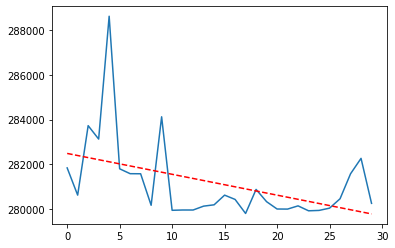

In [9]:
x = [i for i in range(len(losses))]
plt.plot(x,losses)
z = np.polyfit(x, losses, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

In [10]:
hp = False
run_experiment(hp, 2)

saving the data processor
MLflow run_id 3e497682554f45bebc9dffec381ff0a1, experiment_id 2, experiment_name facileai-mlops-webinar-27-05-21
rmse: 279800.59375


# Evaluate the model on the validation set

In [11]:
valid_df = pd.read_csv('./data/mel-valid.csv', low_memory=False)

In [12]:
with open('./artifacts/model.pkl', 'rb') as model_file:
    model = pickle.load(model_file)

In [13]:
with open('./artifacts/data-proc.pkl', 'rb') as preproc_file:
    preproc = pickle.load(preproc_file)

    val_nn = preproc.train.new(valid_df)
    val_nn.process()
    
    X_valid,y_valid = val_nn.train.xs,val_nn.train.y

    print(X_valid.shape,y_valid.shape)

(7634, 12) (7634,)


In [14]:
preds = model.predict(X_valid)
            
rmse = np.sqrt(mean_squared_error(y_valid, preds))
print(rmse)

237115.38171442843
